## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於測試 多通道 高低頻項分解 的模型訓練成果 ###



### 導入模型設定與套件 ###

In [1]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
np.random.seed(42)
random.seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 頻域分解方法 ### 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_5.parquet"
# testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_1800_1_0V\RUL_Data_3_4.parquet"
test_data = read_rul_data(testfile)
start_idx=112

Rs=12.5
Fs=20000

# V/I歷史輸入與未來電壓
vi = np.stack([
    test_data["Voltage alpha downsample"],
    test_data["Voltage beta downsample"],
    test_data["Current alpha downsample"],
    test_data["Current beta downsample"]
], axis=1)  # shape (128, 4)
vi=np.expand_dims(vi, axis=0)

speed= (test_data["Speed"][0]/3000)
torque= (test_data["Torque avg"])

voltage = vi[0, :, 0:2]
current = vi[0, :, 2:4]
emf=(voltage-current*Rs)/(speed*3000/60*2*np.pi)  # 計算電動勢
print(emf.shape)

# === 模擬輸入資料 ===
signal = emf[0, :, 0]  # 取出純 1D 資料 (shape: [8000])

# === 小波分解 ===
wavelet = 'db4'
max_level = pywt.dwt_max_level(data_len=len(signal), filter_len=pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(signal, wavelet=wavelet, level=max_level)

# === 可視化時頻圖：每層係數 ===
plt.figure(figsize=(10, 2 * len(coeffs)))
for i, c in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i+1)
    plt.plot(c)
    if i == 0:
        plt.title(f'Approximation Coefficients (cA{max_level})')
    else:
        plt.title(f'Detail Coefficients (cD{max_level - i + 1})')
plt.tight_layout()
plt.show()

# === 重建每一層頻帶的時間訊號 ===
reconstructed_signals = []
labels = []

# 重建 Approximation (低頻)
approx_only = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
reconstructed_signals.append(pywt.waverec(approx_only, wavelet))
labels.append(f"Approximation (cA{max_level})")

# 重建每一層 Detail (高頻) 成分
for i in range(1, len(coeffs)):
    detail_only = [np.zeros_like(coeffs[0])] + [
        coeffs[j] if j == i else np.zeros_like(coeffs[j])
        for j in range(1, len(coeffs))
    ]
    rec = pywt.waverec(detail_only, wavelet)
    reconstructed_signals.append(rec)
    labels.append(f"Detail (cD{max_level - i + 1})")

# === 畫圖：原始與各頻帶重建 ===
plt.figure(figsize=(12, 2 * (len(reconstructed_signals) + 1)))

# 原始
plt.subplot(len(reconstructed_signals) + 1, 1, 1)
plt.plot(signal)
plt.title("Original Signal")

# 各頻帶重建
for i, rec in enumerate(reconstructed_signals):
    plt.subplot(len(reconstructed_signals) + 1, 1, i+2)
    plt.plot(rec[:len(signal)])
    plt.title(f"Reconstructed: {labels[i]}")

plt.tight_layout()
plt.show()


(8000, 2)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## 建立 LSTM 預測模型架構 ##
I2 in I2 out

### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

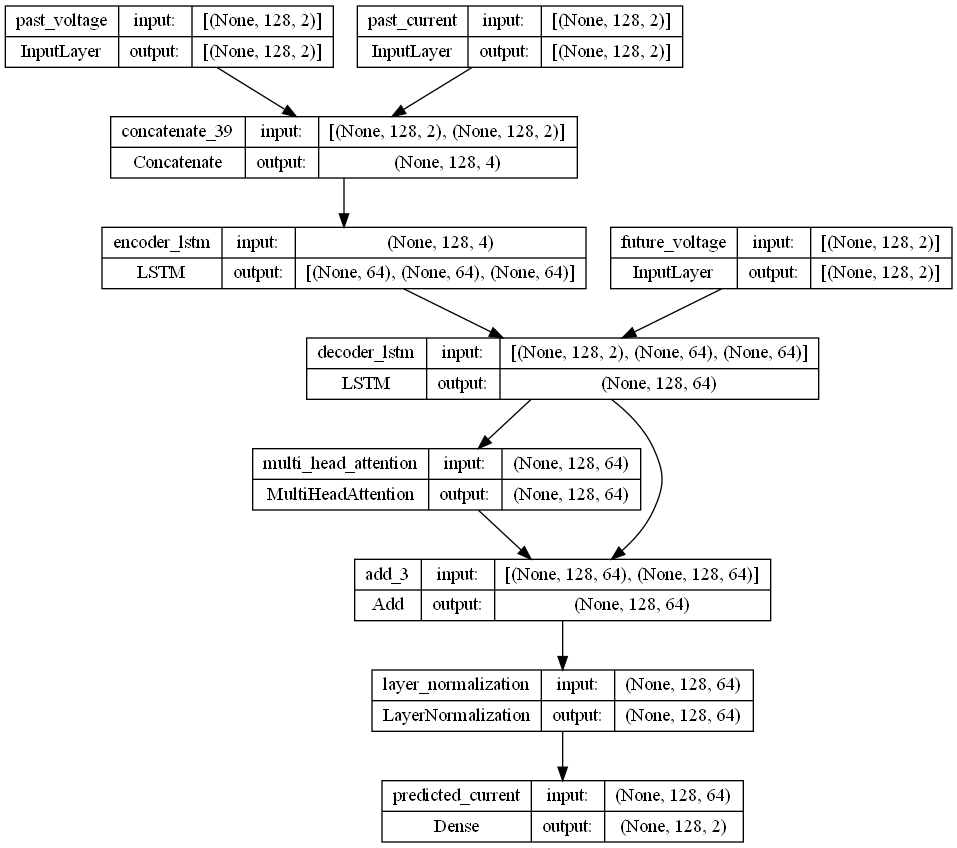

In [101]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import backend as K

# Initial model parameters
sequence_length=128
layer_number=1
future_length=128

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'CCAE_direct_lstm_SigleLayer{layer_number}Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_direct_lstm_with_future_x(seq_len=128, x_dim=2, y_dim=2,
                                    lstm_units=64, forecast_horizon=future_length):
    """
    Direct LSTM forecasting model with future voltage input,
    using stacked Bidirectional decoder LSTM layers (no residual).
    """

    # ===== Encoder =====
    x_past_input = Input(shape=(seq_len, x_dim), name='past_voltage_input')
    y_past_input = Input(shape=(seq_len, y_dim), name='past_current_input')
    x_future_input = Input(shape=(forecast_horizon, x_dim), name='future_voltage_input')

    encoder_input = Concatenate(axis=-1, name='encoder_concat')([x_past_input, y_past_input])  # shape: (seq_len, 4)
    encoder_output, state_h, state_c = LSTM(lstm_units, return_state=True, name='encoder_lstm')(encoder_input)

    # ===== Decoder =====
    decoder_input = x_future_input  # shape: (forecast_horizon, x_dim)
    decoder_l1 = LSTM(lstm_units, return_sequences=True, name='decoder_lstm')(decoder_input, initial_state=[state_h, state_c])

    # ===== Output =====
    output = TimeDistributed(Dense(y_dim, name='output_dense'), name='output_time_distributed')(decoder_l1)  # shape: (forecast_horizon, y_dim)

    model = Model(inputs=[x_past_input, y_past_input, x_future_input], outputs=output, name='direct_lstm_with_future_x')
    return model

def build_lstm_with_attention(past_len=128, future_len=32, x_dim=1, y_dim=1,
                              lstm_units=64, d_model=64, n_heads=4):
    # === Input ===
    x_past = Input(shape=(past_len, x_dim), name='past_voltage')
    y_past = Input(shape=(past_len, y_dim), name='past_current')
    x_future = Input(shape=(future_len, x_dim), name='future_voltage')

    # === Encoder LSTM (past: V + I)
    encoder_input = Concatenate()([x_past, y_past])
    _, state_h, state_c = LSTM(lstm_units, return_state=True, name='encoder_lstm')(encoder_input)

    # === Decoder LSTM (future: V)
    decoder_output = LSTM(lstm_units, return_sequences=True, name='decoder_lstm')(
        x_future, initial_state=[state_h, state_c]
    )

    # === Self-Attention over decoder output
    attn_output = MultiHeadAttention(num_heads=n_heads, key_dim=d_model)(decoder_output, decoder_output)
    attn_output = Add()([decoder_output, attn_output])   # Residual connection
    attn_output = LayerNormalization()(attn_output)

    # === Dense projection to predicted current
    output = Dense(y_dim, name='predicted_current')(attn_output)

    return Model(inputs=[x_past, y_past, x_future], outputs=output, name='LSTM_Attn_Predictor')

def mse_with_diff_loss(y_true, y_pred, alpha=0.1):
    """
    y_true, y_pred: shape = (batch_size, time_steps, features)
    alpha: 權重係數，控制差分損失的強度
    """
    # 原始 MSE 損失
    base_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # 一階差分（沿時間軸 axis=1）
    dy_true = y_true[:, 1:, :] - y_true[:, :-1, :]
    dy_pred = y_pred[:, 1:, :] - y_pred[:, :-1, :]
    diff_loss = tf.reduce_mean(tf.square(dy_true - dy_pred))

    # 加權總損失
    return base_loss + alpha * diff_loss

# build model 
my_model = build_direct_lstm_with_future_x(seq_len=sequence_length, x_dim=2, y_dim=2, lstm_units=64, forecast_horizon=future_length)


my_model = build_lstm_with_attention(past_len=sequence_length, future_len=future_length, x_dim=2, y_dim=2,lstm_units=64, d_model=64, n_heads=4)
my_model.compile(optimizer='adam', loss='mse')
# my_model.compile(optimizer='adam', loss=lambda y_true, y_pred: mse_with_diff_loss(y_true, y_pred, alpha=0.2))

metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

        
        
plot_model(my_model, to_file=os.path.join(model_path, model_name+'.png'), show_shapes=True, show_layer_names=True)


### 資料前處理 ###

In [ ]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt

def split_low_high(signal, cutoff=0.1, fs=1.0, order=2):
    """
    將時間序列分成低頻與高頻項
    signal: ndarray (time, features)
    return: low_passed, high_passed
    """
    b, a = butter(order, Wn=cutoff, btype='low', fs=fs)
    low = filtfilt(b, a, signal, axis=0)
    high = signal - low
    return low, high




# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data


# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["1800_0_5V","1800_1_0V", "1800_2_0V"]  # 選擇特定資料夾
# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []
for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2)
       
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

train_signals=[]

for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  np.array(df["Current alpha downsample"]),
                                  np.array(df["Current beta downsample"])] 
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=1000,future_length=future_length)
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個

print(f"Train  signals shape: {train_signals.shape}")
print(f"Train input signals shape: {train_input_signals[:,:,0:2].shape}")
print(f"Train fit signals shape: {train_fit_signals.shape}")

    

Train  signals shape: (45000, 256, 4)
Train input signals shape: (45000, 128, 2)
Train fit signals shape: (45000, 128, 4)


### 模型訓練 ###

Epoch 1/20
633/633 [==============================] - 13s 18ms/step - loss: 0.0341 - val_loss: 0.0021
Epoch 2/20
633/633 [==============================] - 11s 17ms/step - loss: 0.0014 - val_loss: 9.2197e-04
Epoch 3/20
633/633 [==============================] - 11s 17ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/20
633/633 [==============================] - 11s 18ms/step - loss: 8.6345e-04 - val_loss: 7.5306e-04
Epoch 5/20
633/633 [==============================] - 11s 17ms/step - loss: 8.1107e-04 - val_loss: 6.4830e-04
Epoch 6/20
633/633 [==============================] - 11s 18ms/step - loss: 7.6842e-04 - val_loss: 5.8297e-04
Epoch 7/20
633/633 [==============================] - 11s 17ms/step - loss: 6.5147e-04 - val_loss: 7.3450e-04
Epoch 8/20
633/633 [==============================] - 11s 18ms/step - loss: 6.5506e-04 - val_loss: 7.1354e-04
Epoch 9/20
633/633 [==============================] - 11s 17ms/step - loss: 6.5717e-04 - val_loss: 6.6054e-04
Epoch 10/20
633/633 [=========

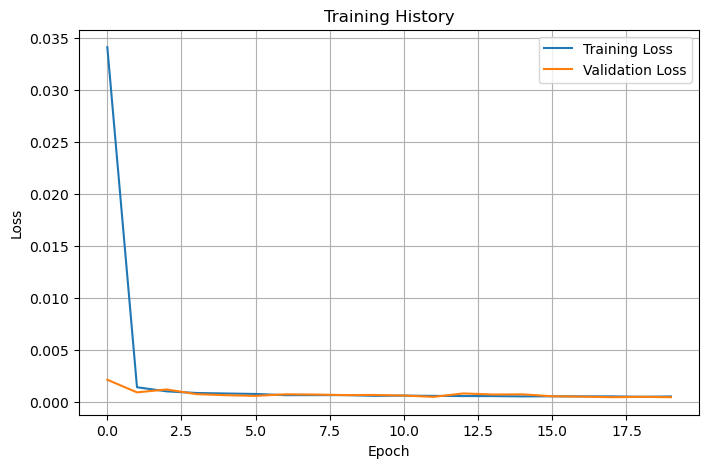

In [103]:
history = my_model.fit([train_input_signals[:,:,0:2], train_input_signals[:,:,2:4], train_fit_signals[:,:,0:2]], train_fit_signals[:,:,2:4],
          batch_size=64, epochs=20, validation_split=0.1)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
print(f"Train input signals shape: {train_input_signals.shape}")

Train input signals shape: (45000, 128, 4)


### 驗證結果 ###

(128, 2)
(128, 2)
(128, 2)


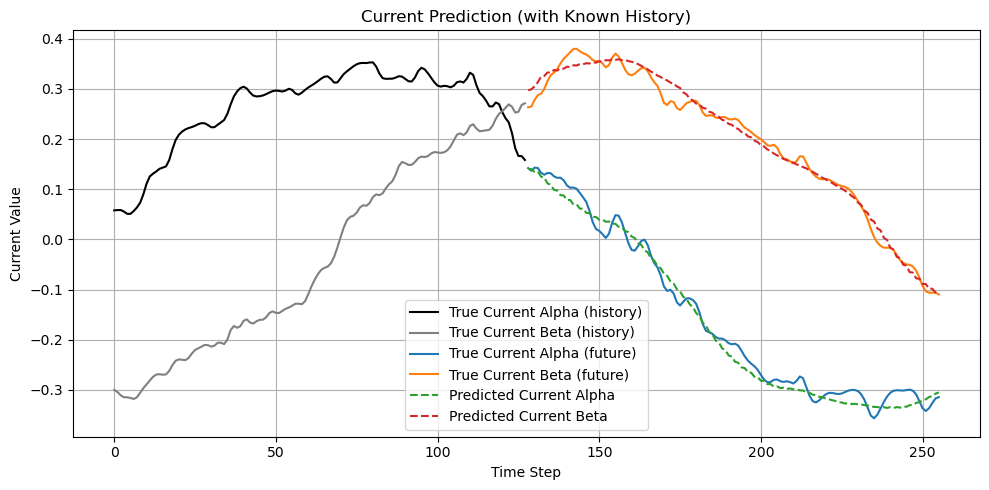

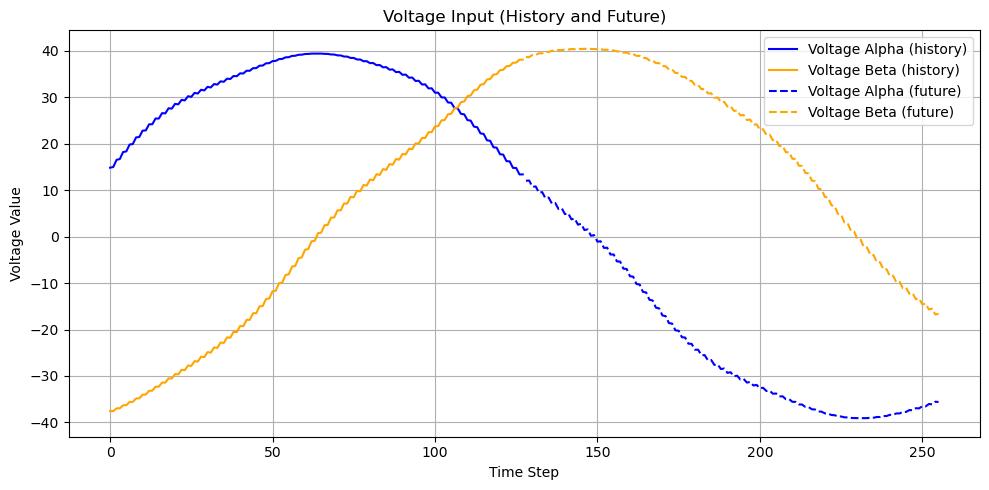

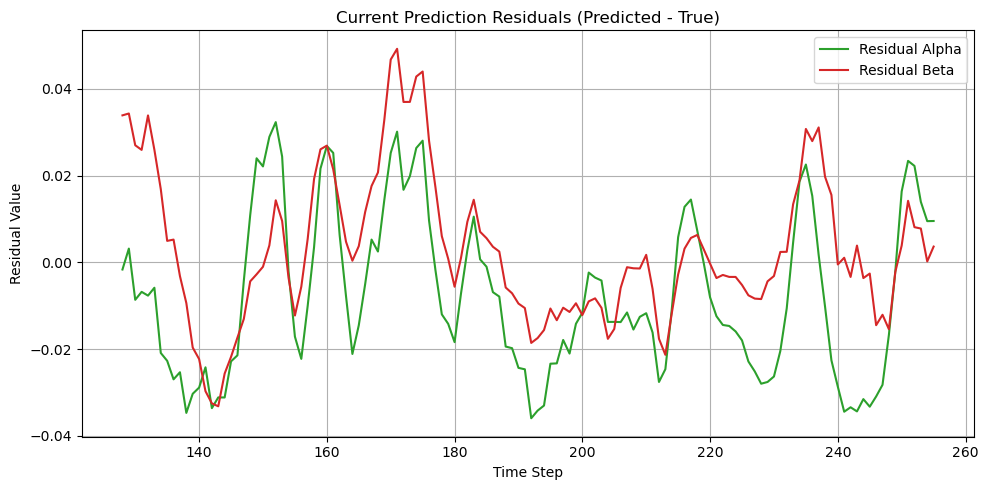

In [105]:
import tensorflow as tf

@tf.function
def fast_iterative_forecast(model, init_voltage, init_current, future_voltage_seq):
    """
    init_voltage: (128, 2)  float32
    init_current: (128, 2)  float32
    future_voltage_seq: (n, 2) float32
    return: (n, 2) predicted current
    """

    n = tf.shape(future_voltage_seq)[0]
    hist_x = tf.TensorArray(dtype=tf.float32, size=129, dynamic_size=True)
    hist_y = tf.TensorArray(dtype=tf.float32, size=129, dynamic_size=True)

    hist_x = hist_x.scatter(tf.range(0, 128), init_voltage)
    hist_y = hist_y.scatter(tf.range(0, 128), init_current)

    output_y = tf.TensorArray(dtype=tf.float32, size=n)

    def condition(i, *_):
        return i < n

    def body(i, hist_x, hist_y, output_y):
        input_x = hist_x.gather(tf.range(i, i + 128))
        input_y = hist_y.gather(tf.range(i, i + 128))

        # predict next y
        pred = model([tf.expand_dims(input_x, 0), tf.expand_dims(input_y, 0)], training=False)[0]

        output_y = output_y.write(i, pred)

        # 更新歷史 x, y
        hist_x = hist_x.write(i + 128, future_voltage_seq[i])
        hist_y = hist_y.write(i + 128, pred)

        return i + 1, hist_x, hist_y, output_y

    i0 = tf.constant(0)
    _, _, _, output_y = tf.while_loop(
        cond=condition,
        body=body,
        loop_vars=[i0, hist_x, hist_y, output_y],
        parallel_iterations=1
    )

    return output_y.stack()


def iterative_forecast(model, voltage_seq, current_seq, future_voltage_seq):
    """
    voltage_seq: shape (128, 2)  # 歷史電壓
    current_seq: shape (128, 2)  # 歷史電流
    future_voltage_seq: shape (n, 2)  # 未來電壓序列
    return: predicted_currents: shape (n, 2)
    """
    history_x = voltage_seq.copy()
    history_y = current_seq.copy()

    predicted_currents = []

    for i in range(len(future_voltage_seq)):
        # 預測下一步電流 (加入batch 維度)
        y_pred = model.predict(
            [history_x[np.newaxis], history_y[np.newaxis]], verbose=0
        )[0]  # shape: (2,)

        # 更新輸入序列
        history_x = np.vstack([history_x[1:], future_voltage_seq[i:i+1]])
        history_y = np.vstack([history_y[1:], y_pred[np.newaxis]])
        
        predicted_currents.append(y_pred)
        
        # print(f"step predicted: {i}")

    return np.array(predicted_currents)


def direct_forecast(model, past_voltage, past_current, future_voltage):
    """
    Direct forecasting function using a direct model.

    Parameters:
    - past_voltage: (128, 2) float32 → 歷史電壓
    - past_current: (128, 2) float32 → 歷史電流
    - future_voltage: (n, 2) float32 → 未來電壓序列

    Returns:
    - predicted_currents: (n, 2) float32
    """
    # 加入 batch 維度 → (1, seq_len, 2)
    x_input = np.expand_dims(past_voltage, axis=0).astype(np.float32)
    y_input = np.expand_dims(past_current, axis=0).astype(np.float32)
    x_future = np.expand_dims(future_voltage, axis=0).astype(np.float32)

    # 模型輸出 shape: (1, n, 2)
    y_future_pred = model.predict([x_input, y_input, x_future], verbose=0)

    return y_future_pred[0]  # 去掉 batch 維度

#----------------------------------------------------------------------------------
test_data=read_rul_data(val_files[1])
#----------------------------------------------------------------------------------

predict_length=512

x_128= np.array([test_data["Voltage alpha downsample"][0:sequence_length], 
                            test_data["Voltage beta downsample"][0:sequence_length]]).T
y_128 = np.array([test_data["Current alpha downsample"][0:sequence_length], 
                            test_data["Current beta downsample"][0:sequence_length]]).T
x_future = np.array([test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length], 
                            test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]]).T
print(x_128.shape)
print(y_128.shape)
print(x_future.shape)
y_future_pred = direct_forecast(my_model, x_128, y_128, x_future)


plt.figure(figsize=(10, 5))
true_future_current = np.array([
    test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
]).T
# 已知資料（前128點）
plt.plot(range(sequence_length), y_128[:, 0], color='black', label='True Current Alpha (history)')
plt.plot(range(sequence_length), y_128[:, 1], color='gray', label='True Current Beta (history)')

# 未來預測部分（128點）
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 0], color='tab:blue', label='True Current Alpha (future)')
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 1], color='tab:orange', label='True Current Beta (future)')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted Current Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted Current Beta')

plt.title('Current Prediction (with Known History)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
# 已知電壓（前128點）
plt.plot(range(sequence_length), x_128[:, 0], color='blue', label='Voltage Alpha (history)')
plt.plot(range(sequence_length), x_128[:, 1], color='orange', label='Voltage Beta (history)')
# 未來電壓（預測區間）
plt.plot(range(sequence_length, sequence_length+future_length), x_future[:future_length, 0], color='blue', linestyle='--', label='Voltage Alpha (future)')
plt.plot(range(sequence_length, sequence_length+future_length), x_future[:future_length, 1], color='orange', linestyle='--', label='Voltage Beta (future)')
plt.title('Voltage Input (History and Future)')
plt.xlabel('Time Step')
plt.ylabel('Voltage Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
residuals = y_future_pred - true_future_current
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label='Residual Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label='Residual Beta')
plt.title('Current Prediction Residuals (Predicted - True)')
plt.xlabel('Time Step')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


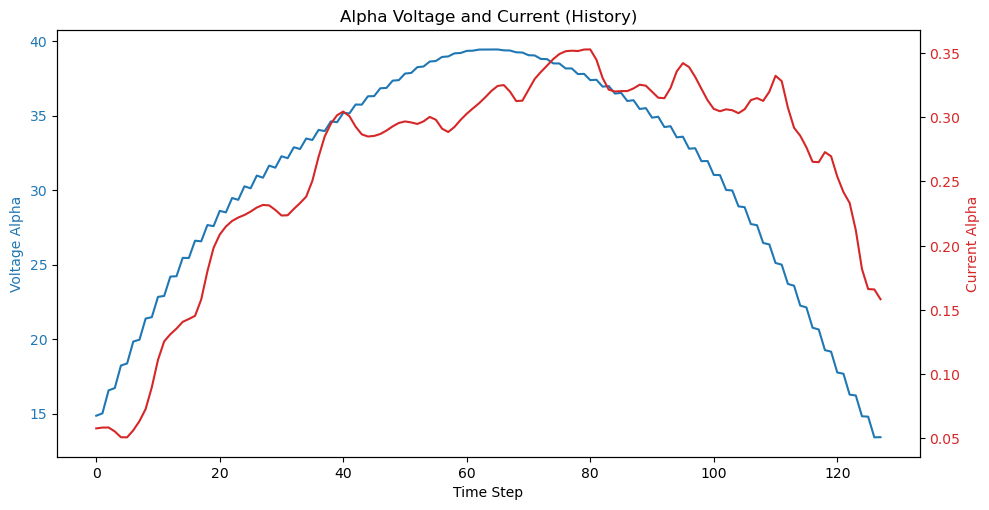

In [106]:

fig, ax1 = plt.subplots(figsize=(10, 5))
# 畫 alpha 電壓 (x_128[:, 0])
color = 'tab:blue'
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Voltage Alpha', color=color)
ax1.plot(range(sequence_length), x_128[:, 0], color=color, label='Voltage Alpha')
ax1.tick_params(axis='y', labelcolor=color)

# 新增第二個 y 軸畫 alpha 電流 (y_128[:, 0])
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Current Alpha', color=color)
ax2.plot(range(sequence_length), y_128[:, 0], color=color, label='Current Alpha')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Alpha Voltage and Current (History)')
plt.show()